## Aryan           379500 
## Kanan Singla    379610 
## Lokesh Sodhi    379613 

## Sentiment Analysis with DistilBERT and Tensorflow

In [ ]:
!pip install tensorflow transformers

In [ ]:
# To finetune transformer model, we need following libraries
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

# To save our trained model, we import pickle library
import pickle

# To pre-process, we need following libraries
import pandas as pd
import numpy as np
import seaborn as sns

# To explre and visualize data, we need following libraries
import matplotlib.pyplot as plt
import plotly.express as px

In this notebook, we will explore sentiment analysis using `TFDistilBertForSequenceClassification` from the HuggingFace🤗Transformers library.

We will classify reviews as positive or negative based on the sentiment of the reviews

**This case study has 5 steps:**
1. Preprocessing the data
2. Fine-tuning the model
3. Testing the model
4. Using the fine-tuned model to predict new samples
5. Saving and loading the model for future use



**Why DistilBERT?**

- DistilBERT is a lighter and faster version of BERT in simple terms.
- It consists of 6 encoder blocks (BERT had 12 encoder blocks stacked up). Inspite of this, it retains 97% of the functionality provided by BERT
- To summarize, DistlBERT is 40% smaller than original BERT base model, and it 60% faster to train than the original BERT model.
- Note: DisltiBERT was trained using only masked language modeling (and not next sentence prediction)

Link to the dataset: https://www.kaggle.com/datasets/sid321axn/amazon-alexa-reviews

### **Step 1: Load & Explore the Data**

In [ ]:
df=pd.read_csv('amazon_alexa.tsv',sep='\t')

In [ ]:
# Read top 5 rows of the dataset
df.head()

In [ ]:
df.iloc[111:112,3:5]

In [ ]:
df[df['feedback']==0].head()

In [ ]:
df.shape

In [ ]:
df['feedback'].value_counts()

1.1 **Check whether data is balanced or not**

In [ ]:
df_plot=df.groupby(by=['feedback']).size().reset_index(name='count')
px.bar(df_plot,x='feedback',y='count')

- We can notice that there are lot more positive reviews than negative reviews in our given data.
- It is a good example of a real life scenario

**Insights:**
1. People tend to not give negative reviews. There are very few instances where customers express negative reviews
2. Or the product by default is good enough and doesn't have many negative reviews.

In [ ]:
# Check the shape of dataframe having only negative reviews i.e. feedback=0
df[df['feedback']==0].shape

In [ ]:
# Check the shape of dataframe having only positive reviews i.e. feedback=1
df[df['feedback']==1].shape

- As we can see here, we have only 257 negative reviews, where as there are 2893 positive reviews.
- Hence, to have balanced distribution of classes, we will downsample positive reviews by randomly selecting any 257 positive reviews.

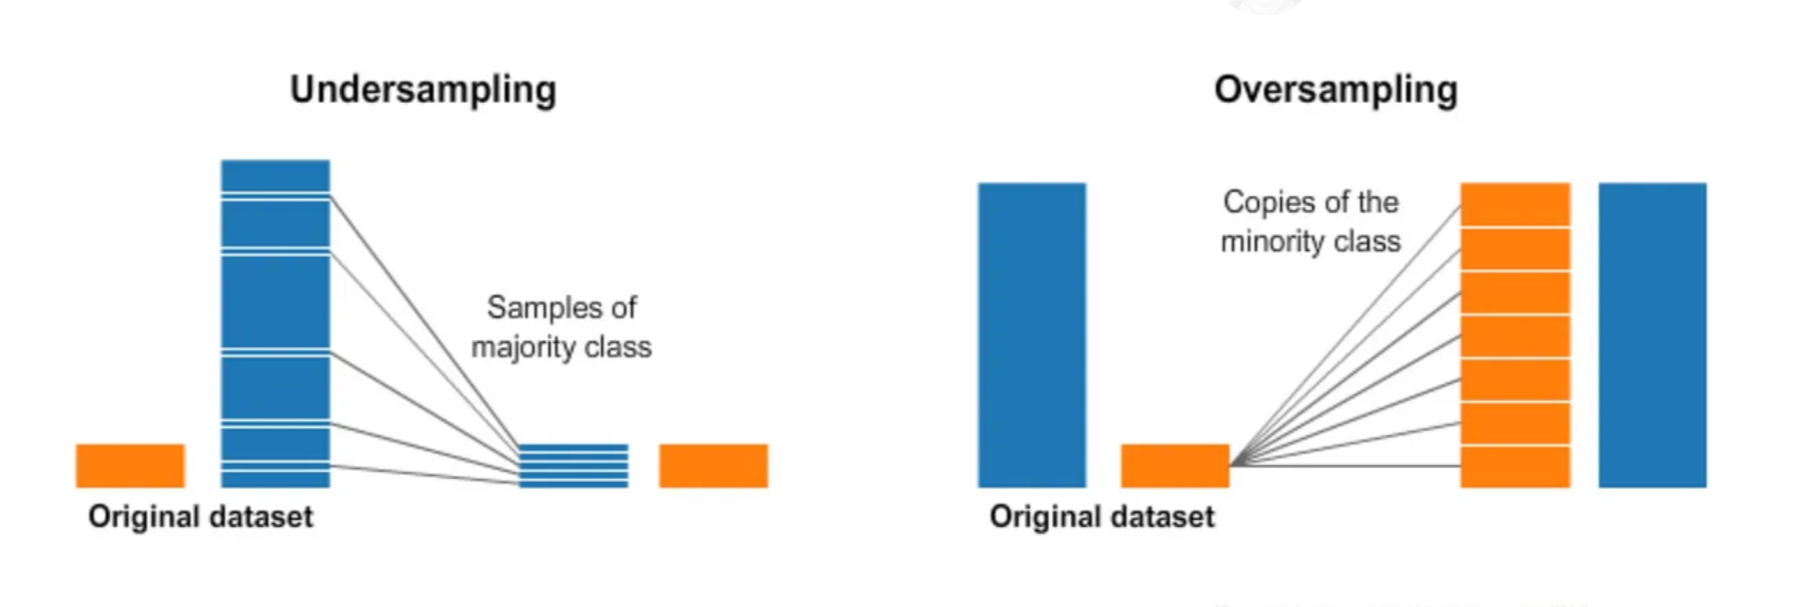

In [ ]:
# Create a dataframe with only negative reviews
df_negative=df[df['feedback']==0]
# Create a dataframe with only positive reviews
df_positive=df[df['feedback']==1]

In [ ]:
df_negative['verified_reviews'].iloc[4]

In [ ]:
# Check number of rows of negative reviews
df_negative.shape[0]

In [ ]:
# Down sample positive reviews to match number of negative reviews
df_positive_downsampled=df_positive.sample(df_negative.shape[0])
df_positive_downsampled.shape

In [ ]:
# Create a balanced dataset of equal number of positive and negative reviews
df_balanced=pd.concat([df_positive_downsampled,df_negative],axis=0)
df_balanced.shape

In [ ]:
# Check the review distribution
df_plot=df_balanced.groupby(by=['feedback']).size().reset_index(name='count')
px.bar(df_plot,x='feedback',y='count')

#sns.countplot(df_balanced['feedback'])

 **1.2 Check length of reviews**
- Another important step is to check the length of reviews as we need to specify the number of tokens to consider for fine tuning.

In [ ]:
df_balanced['review_length']=df_balanced['verified_reviews'].apply(lambda x: len(x.split()))

In [ ]:
df_balanced.shape

In [ ]:
fig=px.histogram(df_balanced['review_length'],title='Review Length')
fig.show()

In [ ]:
# Converting dataframe series object into list
x=df_balanced['verified_reviews'].to_list()
x[0:5]

In [ ]:
# Converting dataframe series object into list
y=df_balanced['feedback'].to_list()

In [ ]:
y[0:5]

**### Step 2. Preprocessing the data**

We will use DistilBertTokenizer for this task.

In [ ]:
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 50 # this is a hyper-parameter

review = "Best thing I've invested in a while thank you so much 😁😁😁😁"

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

inputs = tokenizer(review, max_length=MAX_LEN, truncation=True,padding='max_length')


In [ ]:
tokenized_words=tokenizer.convert_ids_to_tokens(inputs["input_ids"])
print(tokenized_words)

In [ ]:
print(f'review: \'{review}\'')
print(f'input ids: {inputs["input_ids"]}')
print(f'attention mask: {inputs["attention_mask"]}')

In [ ]:
def construct_encodings(x, tokenizer, max_len, trucation=True, padding=True):
    return tokenizer(x, max_length=max_len, truncation=trucation, padding=padding)

encodings = construct_encodings(x, tokenizer, max_len=MAX_LEN)

The first stage of preprocessing is done! The second stage is converting our `encodings` and `y` (which holds the classes of the reviews) into a Tensorflow Dataset object. 

In [ ]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))

In [ ]:
tfdataset = construct_tfdataset(encodings, y)

The third and final preprocessing step is to create training and test sets:

In [ ]:
# All these are hyper-parameters
TEST_SPLIT = 0.2
VAL_SPLIT=0.2
BATCH_SIZE = 32

# Initial training size
train_size = int(len(x) * (1-TEST_SPLIT))
val_size=int(len(x) * (VAL_SPLIT))

# At this step, we're only declaring the train & test size
print('Initial Train size is: ',train_size)
print('Test size is: ',int(len(x) * (TEST_SPLIT)))
print('Validation size is: ',val_size)

In [ ]:
# Shuffling
tfdataset = tfdataset.shuffle(len(x)) # randomly shuffles dataset across dimension of x tensor vector

# Testing data: tfdataset.skip(3) --> will skip inital 3 rows from the dataset. So tfdataset.skip(train_size) will skip initial 411 rows and keep remaining 102 into tfdataset_test
tfdataset_test = tfdataset.skip(train_size)

# Remaining data: tfdataset.take(3) --> will take first 3 rows from the dataset. So tfdataset.take(train_size) will store first 411 rows into tfdataset_rest
tfdataset_rest = tfdataset.take(train_size)

# Now we will split tfdataset_rest into train and validation datasets using val_size=51
tfdataset_train=tfdataset_rest.skip(val_size)
tfdataset_val=tfdataset_rest.take(val_size)

print('Train size is: ',len(tfdataset_train))
print('Test size is: ',len(tfdataset_test))
print('Validation size is: ',len(tfdataset_val))


In [ ]:
# tfdataset_train.batch creates batches of the data, each batch having number of samples equal to the batch size
tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_val = tfdataset_val.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [ ]:
print('Number of batches of Training data: ',len(tfdataset_train))
print('Number of batches of Testing data: ',len(tfdataset_test))
print('Number of batches of Validation data: ',len(tfdataset_val))

**So to conclude:**
- Training sample of 309 instances is divided into 10 batches each batch having approximately 32 samples. (Last batch will have 21 samples) | 32 x 9 + 21 = 309
- Validation sample of 103 instances is divided into 4 batches each having approximately 32 samples. (last batch will have 7 samples) | 32 x 3 + 7 = 103
- Validation sample of 103 instances is divided into 4 batches each having approximately 32 samples. (last batch will have 6 samples) | 32 x 3 + 6 = 102


### **Step 2. Fine-tuning the model**


In [ ]:
N_EPOCHS = 10 # This is a hyper-parameter
MODEL_NAME = 'distilbert-base-uncased'

model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2) # num_labels--> is the number of classes in target class. Here we have 2 classes (1: Positive, 0:Negative)
optimizer = optimizers.Adam(learning_rate=3e-5) # Learning rate is another hyper-parameter
loss = losses.SparseCategoricalCrossentropy(from_logits=True) # SparseCategoricalCrossentropy is used when our target class is integer encoded.  (1: Positive, 0:Negative)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
history=model.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS,validation_data=tfdataset_val,verbose=1)

- The training accuracy and validation accuracy is almost equal to 95%, which indicates that the model doesn't overfit
- Moreover, the below curves of training & validation loss versus number of epochs is smooth and reducing which indicates this is a good model and an epoch of 5 or 6 is enough to train this model.

In [ ]:
def plot_metric(history,metric):
    training_metrics=history.history[metric]
    validation_metrics=history.history['val_'+metric]
    epochs=range(1,len(training_metrics)+1)
    plt.plot(epochs,training_metrics)
    plt.plot(epochs,validation_metrics)
    plt.title('Training and Validation '+metric)
    plt.xlabel("Number of Epochs")
    plt.ylabel(metric)
    plt.ylim([0,1.5])
    plt.legend(["training_"+metric, 'validation_'+metric])
    plt.show()

In [ ]:
plot_metric(history, 'loss')

### **3. Testing the model**

Now we can use our test set to evaluate the performance of the model.

In [ ]:
# Using moedl.evaluate() we test the model performance on unseed data which is stored in tfdataset_test
benchmarks = model.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE,verbose=1)
print(benchmarks)

- It can be noted that, the performance of model on training, validation, testing dataset is more or less the same, which is a sign of good model.
- In this way, we can see how efficiently DistilBERT acheives accuracy of 99% on test data and 98 % on training data

### **Step 4. Using the fine-tuned model to predict new samples**

Now that we've trained the model, we can use it to predict new samples. Below is a function whose output is a classifier we can use for predictions:

In [ ]:
def create_predictor(model, model_name, max_len):
  tokenizer = DistilBertTokenizer.from_pretrained(model_name)
  def predict_proba(text):
      x = [text]

      encodings = construct_encodings(x, tokenizer, max_len=max_len)
      tfdataset = construct_tfdataset(encodings)
      tfdataset = tfdataset.batch(1)

      preds = model.predict(tfdataset).logits
      #print("pred logits: ",preds)
      preds = activations.softmax(tf.convert_to_tensor(preds)).numpy()
      #print("softmax o/p: ",preds)
      return preds[0][1]

  return predict_proba



In [ ]:
clf = create_predictor(model, MODEL_NAME, MAX_LEN)
print(clf("TalentServe is one of the best out there!"))

### **Step 5. Saving and loading the model for future use**

In [ ]:
model.save_pretrained('./model/clf')
with open('./model/info.pkl', 'wb') as f:
    pickle.dump((MODEL_NAME, MAX_LEN), f)